In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Agent:
    """
    A reinforcement learning agent for the CartPole environment that uses Q-learning.

    Parameters
    ----------
    gamma : float, optional
        The discount factor for future rewards, by default 0.99.
    alpha : float, optional
        The learning rate, by default 0.1.

    Attributes
    ----------
    pole_angle_bins : ndarray
        Bins for discretizing the pole angle.
    pole_velocity_bins : ndarray
        Bins for discretizing the pole velocity.
    cart_position_bins : ndarray
        Bins for discretizing the cart position.
    cart_velocity_bins : ndarray
        Bins for discretizing the cart velocity.
    action_space : list
        The list of possible actions (e.g., [0, 1] for left and right).
    Q : dict
        The Q-table for storing state-action values.
    """

    def __init__(self, gamma=0.99, alpha=0.1):
        self.pole_angle_bins = np.linspace(-0.2095, 0.2095, 10)
        self.pole_velocity_bins = np.linspace(-4, 4, 10)
        self.cart_position_bins = np.linspace(-2.4, 2.4, 10)
        self.cart_velocity_bins = np.linspace(-4, 4, 10)
        self.action_space = [0, 1]
        self.Q = {}
        self.gamma = gamma
        self.alpha = alpha

        self.init_Q()

    def init_Q(self):
        """
        Initializes the Q-table with all zeros for every state-action pair.
        """
        for p_angle in range(len(self.pole_angle_bins) + 1):
            for p_velocity in range(len(self.pole_velocity_bins) + 1):
                for c_position in range(len(self.cart_position_bins) + 1):
                    for c_velocity in range(len(self.cart_velocity_bins) + 1):
                        self.Q[(c_position, c_velocity, p_angle, p_velocity)] = {}
                        for action in self.action_space:
                            self.Q[(c_position, c_velocity, p_angle, p_velocity)][
                                action
                            ] = 0

    def epsilon_greedy_policy(self, state, epsilon):
        """
        Selects an action using an epsilon-greedy policy based on the current state.

        Parameters
        ----------
        state : tuple of float
            The current state of the environment.
        epsilon : float
            The probability of selecting a random action.

        Returns
        -------
        int
            The action selected.
        """
        if np.random.random() < epsilon:  # explore
            return np.random.choice(self.action_space)
        else:  # exploit
            return self.greedy_policy(self.make_discrete(state))

    def greedy_policy(self, state):
        """
        Selects the action with the highest value from the Q-table for a given state.

        Parameters
        ----------
        state : tuple of int
            The discretized state of the environment.

        Returns
        -------
        int
            The action selected.
        """
        return np.argmax(list(self.Q[state].values()))

    def make_discrete(self, state):
        """
        Discretizes a continuous state into bins.

        Parameters
        ----------
        state : tuple of float
            The continuous state to be discretized.

        Returns
        -------
        tuple of int
            The discretized state.
        """
        return (
            np.digitize(state[0], self.cart_position_bins),
            np.digitize(state[1], self.cart_velocity_bins),
            np.digitize(state[2], self.pole_angle_bins),
            np.digitize(state[3], self.pole_velocity_bins),
        )

    def update_Q(self, state, action, reward, next_state):
        """
        Updates the Q-table using the Q-learning algorithm.

        Parameters
        ----------
        state : tuple of float
            The current state.
        action : int
            The action taken.
        reward : float
            The reward received.
        next_state : tuple of float
            The next state.

        """
        state = self.make_discrete(state)
        next_state = self.make_discrete(next_state)
        self.Q[state][action] = self.Q[state][action] + self.alpha * (
            reward
            + self.gamma * max(self.Q[next_state].values())
            - self.Q[state][action]
        )

In [6]:
def plot_running_average(scores):
    """
    Plots the running average of a list of scores.

    Parameters
    ----------
    scores : list of float
        The list of scores to plot.
    """
    running_average = np.zeros(len(scores))
    for i in range(len(running_average)):
        running_average[i] = np.mean(scores[max(0, i - 100) : i + 1])
    plt.plot(np.arange(len(running_average)), running_average)
    plt.show()

In [3]:
def main():
    """
    Main function to execute the CartPole environment training using Q-learning.
    """
    env = gym.make("CartPole-v1")

    agent = Agent()
    n_episodes = 50000
    epsilon = 1
    epsilon_step = 2 / n_episodes

    rewards = []

    for episode in range(n_episodes):
        print("Executing episode:", episode + 1, end="\r")
        state, _ = env.reset()

        score = 0
        terminated, truncated = False, False
        while not terminated and not truncated:
            action = agent.epsilon_greedy_policy(state, epsilon)
            state_, reward, terminated, truncated, _ = env.step(action)
            agent.update_Q(state, action, reward, state_)
            state = state_
            score += reward

        if epsilon > 0.01:
            epsilon = max(epsilon - epsilon_step, 0.01)

        rewards.append(score)

    print("Training Complete!\t\t")
    plot_running_average(rewards)

Training Complete!		0000


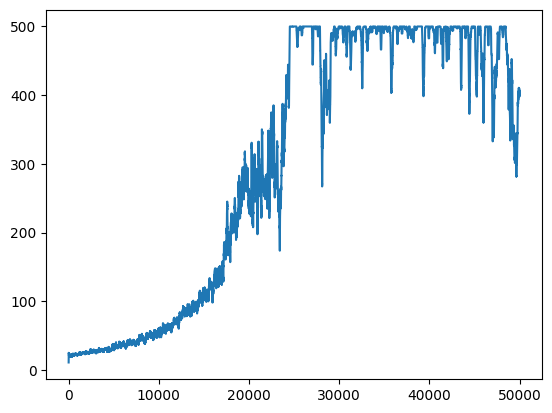

In [5]:
main()